# Nutrient (N, P, Fe) distribution - draft 2

Here I plot the nutrients N, P, and Fe that were simulated by the Darwin global model (Dutkiewicz et al., 2019).

I calculate the nutrient supply ratios phi(P:N) (1) and phi(Fe:N) (2), which are used to describe the excess P and Fe supply. These are the ratio of the gross delivery rate of phosphorus and iron, relative to the gross delivery rate of bioavailable nitrogen, normalized by estimated P:N or Fe:N ratio of nondiazotrophic phytoplankton community (Ward et al., 2013).

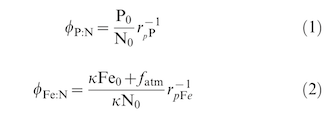

Based on Ward et al. (2013) Web Appendix, I included only components that add dissolved nitrogen, phosphate, or iron to the model surface 100m.\
Assumptions:

- Integrate over top 100m (= first 6 depth level of model)
- Multiply each box with its dz --> get mol/m2/s
- Multiply with seconds per year --> get mol/m2/y
- Set negative values to "zero" --> very small value to avoid division by zero
- Sum up transport terms and remineralization terms; iron dust deposition is included in Nutr['gGUD07']
- Also show transport and remin terms alone

#### Load requirements and set switches

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [30]:
#Load data

# iron dust flux
fein = np.fromfile('/Users/meilers/MITinternship/Data/mahowald2009_solubile_current_smooth_oce_mth-2d.bin', '>f4').reshape(12,160,360)

# model simulation output
Nutr = xr.open_dataset('/Users/meilers/MITinternship/Data/Nutr_tend.0000014400.nc')

grid = xr.open_dataset('/Users/meilers/MITinternship/Data/supply50m.nc')

lon = grid.lon   #needed for plotting
lat = grid.lat    #needed for plotting

In [161]:
# transport terms
NH4 = Nutr['gTr02']
NO2 = Nutr['gTr03']
NO3 = Nutr['gTr04']
PO4 = Nutr['gTr05']
FeT = Nutr['gTr07']

# other terms: remineralization and dust in case of Fe
NH4_o = Nutr['gGUD02']
NO2_o = Nutr['gGUD03']
NO3_o = Nutr['gGUD04']
PO4_o = Nutr['gGUD05']
FeT_o = Nutr['gGUD07']

#reducing the T dimension (which is 1 anyway)
NH4 = NH4[0,:,:,:]
NO2 = NO2[0,:,:,:]
NO3 = NO3[0,:,:,:]
PO4 = PO4[0,:,:,:]
FeT = FeT[0,:,:,:]

NH4_o = NH4_o[0,:,:,:]
NO2_o = NO2_o[0,:,:,:]
NO3_o = NO3_o[0,:,:,:]
PO4_o = PO4_o[0,:,:,:]
FeT_o = FeT_o[0,:,:,:]

# define constants and dz
sec = 31557600  #seconds per year (365.25*86400)
dz = [10,10,15,20,20,25] #,35,50,75,100] #(...) dz between two depth layers

Sum nutrients up over depth and multiply with corresponding dz and sec

In [104]:
for i in range(len(dz)):
    NH4_int = NH4[i,:,:]*dz[i]*sec
    #print(np.min(NH4[i,:,:]))
    i+=1

for i in range(len(dz)):
    NO2_int = NO2[i,:,:]*dz[i]*sec
    i+=1
    
for i in range(len(dz)):
    NO3_int = NO3[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    PO4_int = PO4[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    FeT_int = FeT[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    NH4_int_o = NH4_o[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    NO2_int_o = NO2_o[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    NO3_int_o = NO3_o[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    PO4_int_o = PO4_o[i,:,:]*dz[i]*sec
    i+=1

for i in range(len(dz)):
    FeT_int_o = FeT_o[i,:,:]*dz[i]*sec
    i+=1

<span style="color:red">No use of dz but instead sum up over depth</span>

In [162]:
NO3_int = np.sum(NO3[0:6,:,:],axis=0)*sec*100
NO2_int = np.sum(NO2[0:6,:,:],axis=0)*sec*100
NH4_int = np.sum(NH4[0:6,:,:],axis=0)*sec*100
PO4_int = np.sum(PO4[0:6,:,:],axis=0)*sec*100
FeT_int = np.sum(FeT[0:6,:,:],axis=0)*sec*100
NO3_int_o = np.sum(NO3_o[0:6,:,:],axis=0)*sec*100
NO2_int_o = np.sum(NO2_o[0:6,:,:],axis=0)*sec*100
NH4_int_o = np.sum(NH4_o[0:6,:,:],axis=0)*sec*100
PO4_int_o = np.sum(PO4_o[0:6,:,:],axis=0)*sec*100
FeT_int_o = np.sum(FeT_o[0:6,:,:],axis=0)*sec*100

Add up the different N species

In [155]:
N_int = NH4_int + NO3_int + NO2_int
N_int_o = NH4_int_o + NO3_int_o + NO2_int_o

<span style="color:red">Just use NO3 for N</span>

In [163]:
N_int = NO3_int
N_int_o = NO3_int_o

Set all negative values to zero

In [164]:
from copy import deepcopy
N_trans = deepcopy(N_int)
P_trans = deepcopy(PO4_int)
Fe_trans = deepcopy(FeT_int)
N_remin = deepcopy(N_int_o)
P_remin = deepcopy(PO4_int_o)
Fe_other = deepcopy(FeT_int_o)

In [165]:
# loop over depths and over latitude
for i in range(len(lat)):
    N_trans[i,:][N_int[i,:]<0]=10e-08
    #print(np.max(NH4_trans[i,:]))
    i+=1

for i in range(len(lat)):
    P_trans[i,:][PO4_int[i,:]<0]=10e-08
    i+=1

for i in range(len(lat)):
    Fe_trans[i,:][FeT_int[i,:]<0]=10e-08
    i+=1
    
for i in range(len(lat)):
    N_remin[i,:][N_int_o[i,:]<0]=10e-08
    i+=1
    
for i in range(len(lat)):
    P_remin[i,:][PO4_int_o[i,:]<0]=10e-08
    i+=1
    
for i in range(len(lat)):
    Fe_other[i,:][FeT_int_o[i,:]<0]=10e-08
    i+=1    

Define transport, remineralization and nutrient fluxes; add iron flux

In [166]:
f_dust = np.sum(fein,axis=0)*sec # only needed to calculate the Fe remineraliztion
                                 # Fe_other contains dust. If we need Fe remin only: subtract dust
Fe_remin = Fe_other-f_dust

N_tot = np.add(N_trans,N_remin)
P_tot = np.add(P_trans,P_remin)
Fe_tot = np.add(Fe_trans,Fe_other)#,f_dust) #including dust

<span style="color:red">Skip the zeroing out of negative values...</span>

In [131]:
f_dust = np.sum(fein,axis=0)*sec # only needed to calculate the Fe remineraliztion
                                 # Fe_other contains dust. If we need Fe remin only: subtract dust
Fe_remin = FeT_int_o-f_dust

N_tot = np.add(N_int,N_int_o)
P_tot = np.add(PO4_int,PO4_int_o)
Fe_tot = np.add(FeT_int,FeT_int_o)#,f_dust) #including dust

reminder: now we have the following variables: 
- N_tot, P_tot, Fe_tot
- N_trans, P_trans, Fe_trans 
- N_remin, P_remin, Fe_remin

Calculate ratios:

In [167]:
# Bioavailable nutrient supply --> bio_PN, bio_FeN
# Constants
rpP = 0.0625
rpFe = 6.25e-5
k = 0.1

#def div(x,y):
#    if y == 0:
#        return y
#    return x / y

bio_PN_tot = (np.divide(P_tot,N_tot))*(1/rpP)
bio_FeN_tot = (np.divide(Fe_tot,N_tot))*(1/rpFe)

bio_PN_trans = (np.divide(P_trans,N_trans))*(1/rpP)
F = np.add((Fe_trans*k),f_dust)
bio_FeN_trans = (np.divide(F,(N_trans*k)))*(1/rpFe)

bio_PN_remin = (np.divide(P_remin,N_remin))*(1/rpP)
bio_FeN_remin = (np.divide(Fe_remin,N_remin))*(1/rpFe)

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)
/

Plot the nutrient ratios:

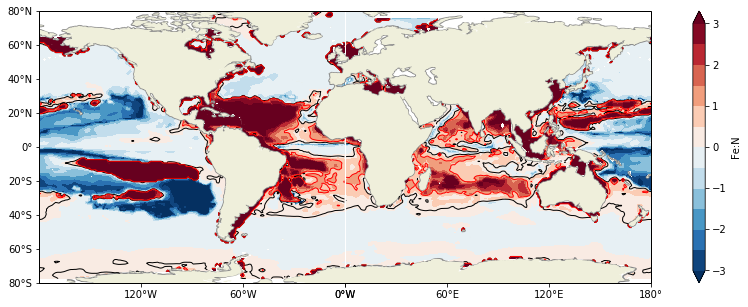

In [170]:
nu = 1   #chose nutrient here: 0=Fe, 1=N, 2=P
nutr = [bio_PN_tot,bio_FeN_tot,bio_PN_trans,bio_FeN_trans,bio_PN_remin,bio_FeN_remin]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N','transport P:N','transport Fe:N','remin P:N','remin Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN,levs_PN,levs_FeN,levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon,lat,np.log(nutr[nu]),levels=levs[nu],cmap=colmap,extend='both')
con1 = ax.contour(lon,lat,nutr[nu],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon,lat,nutr[nu],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nu])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

Plot the ratio for the total, transport and remin terms all together:

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


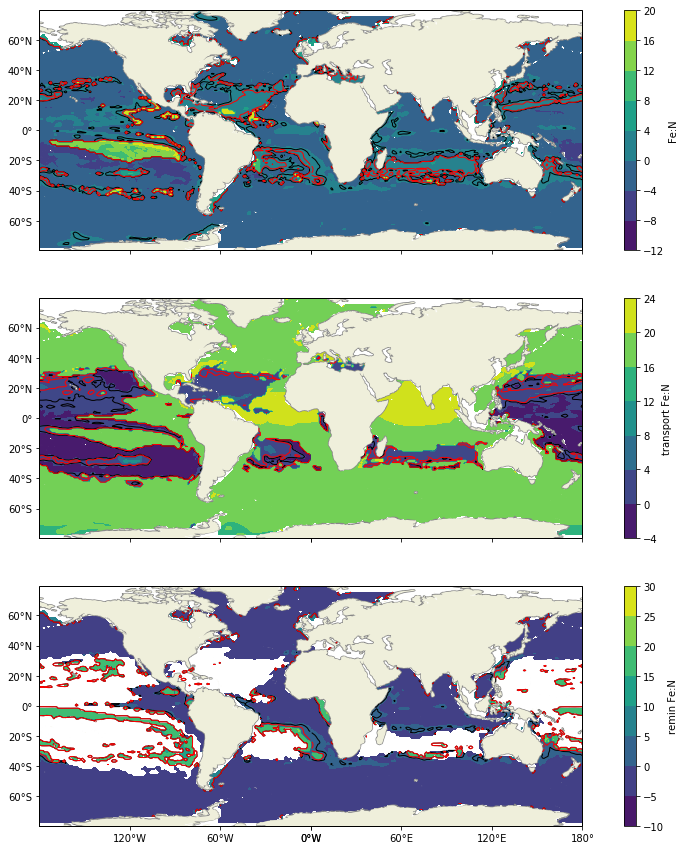

In [71]:
nu = 1   #chose nutrient here: 0=Fe, 1=N, 2=P
nutr = [bio_FeN_tot,bio_FeN_trans,bio_FeN_remin]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['Fe:N','transport Fe:N','remin Fe:N']

levs_FeN = np.linspace(-3,3,13)

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(3,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},sharex=True,sharey=True,figsize=(15,15))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
for i in range(len(nutr)):
    ax[i].coastlines(color='#888888',linewidth=1.5)
    ax[i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
    c = ax[i].contourf(lon,lat,np.log(nutr[i]))#,levels=levs_FeN,cmap=colmap,extend='both')
    con1 = ax[i].contour(lon,lat,nutr[i],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
    con2 = ax[i].contour(lon,lat,nutr[i],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    ax[i].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
    ax[i].set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
    cbar = plt.colorbar(c,ax=ax[i])
    cbar.set_label(''+str(name_nut[i])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

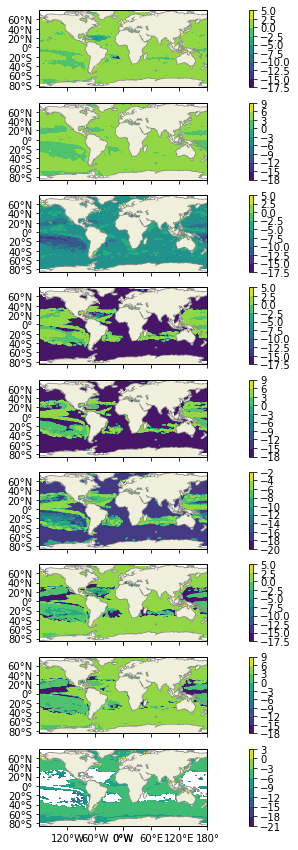

In [64]:
nu = 1   #chose nutrient here: 0=Fe, 1=N, 2=P
nutr = [P_tot,N_tot,Fe_tot,P_trans,N_trans,Fe_trans,P_remin,N_remin,Fe_remin]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['Fe:N','transport Fe:N','remin Fe:N']

levs_FeN = np.linspace(-3,3,13)

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(9,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},sharex=True,sharey=True,figsize=(15,15))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
for i in range(len(nutr)):
    ax[i].coastlines(color='#888888',linewidth=1.5)
    ax[i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
    c = ax[i].contourf(lon,lat,np.log(nutr[i]))#,levels=levs_FeN,cmap=colmap,extend='both')
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    ax[i].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
    ax[i].set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
    cbar = plt.colorbar(c,ax=ax[i])
    #cbar.set_label(''+str(name_nut[i])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

Compare to Ward et al., 2013:

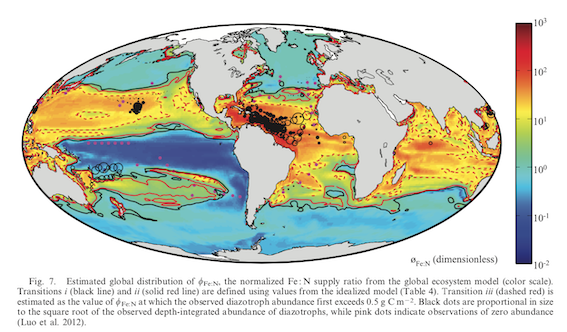

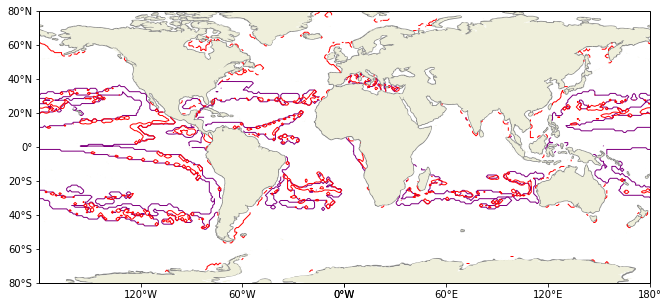

In [49]:
nut = 4   #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN_tot,bio_FeN_tot,bio_PN_T,bio_FeN_T,bio_PN_remin,bio_FeN_remin]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N','transport P:N','transport Fe:N','remin P:N','remin Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN,levs_PN,levs_FeN,levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
#c = ax.contourf(lon1,lat1,nutrient[nut])#,levels=levs[nut],cmap=colmap,extend='max')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.04],colors='purple',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutr[nu],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
#cbar = plt.colorbar(c,ax=ax)
#cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

Compare to Ward et al., 2013:

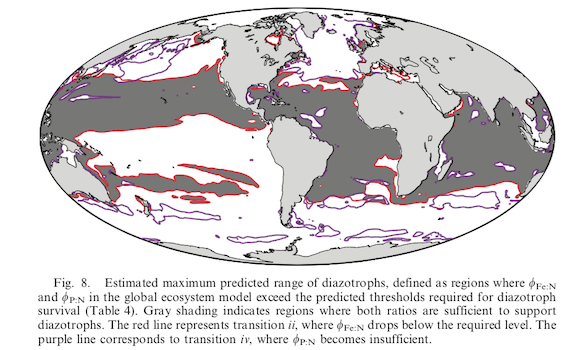

### Now, I'll make a few modifications to see if we can get results which are comparable to Ward et al., 2013.

### Import diazotroph observational data

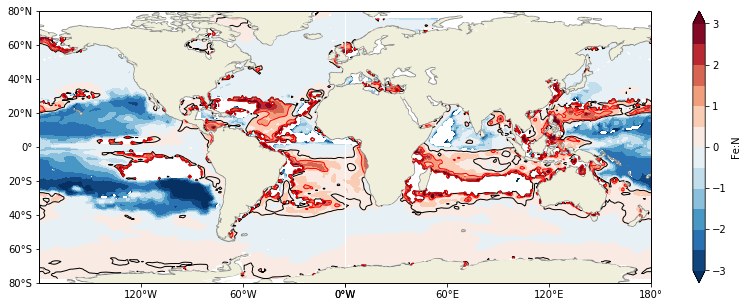

In [27]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN_2D,bio_FeN_2D]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

In [28]:
# Load diazotroph data
ds = Dataset('/Users/meilers/MITinternship/Data/MarEDat20130403Diazotrophs.nc', 'r')

# extract variables which are needed and convert/integrate
lon = ds.variables['LONGITUDE']
lat = ds.variables['LATITUDE']
#lon_new = lon[:] #in case I needed to modify the lon/lat to match it the lon/lat of the nutrients
#lat_new = lat[:]

obs = ds.variables['OBSERVATIONS']
abund = ds.variables['ABUNDANCE']

obs_int = np.sum(obs[:,0:6,:,:],axis=1)
abund_int = np.sum(abund[:,0:6,:,:],axis=1)

obs_tot = np.sum(obs_int,axis=0)
abund_tot = np.sum(abund_int,axis=0)

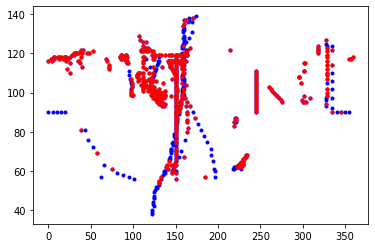

In [29]:
# Create a mask: 0 = absence, 1 = presence
        
mask1 = np.zeros_like(obs_tot)
mask1[obs_tot>0] = 1

mask2 = np.zeros_like(abund_tot)
mask2[abund_tot>0] = 1

find1 = np.where(mask1==1)
find2 = np.where(mask2==1)

plt.plot(find1[1],find1[0],'.',color='b')
plt.plot(find2[1],find2[0],'.',color='r')
plt.show()

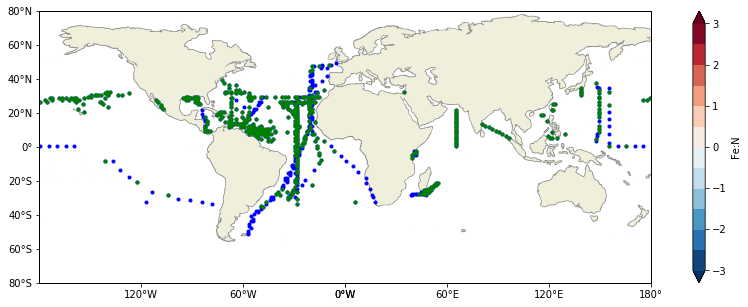

In [30]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
#c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
#con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
#con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
plt.plot(lon[find1[1]],lat[find1[0]],'.',color='b',label='obs')
plt.plot(lon[find2[1]],lat[find2[0]],'.',color='g',label='abund')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()

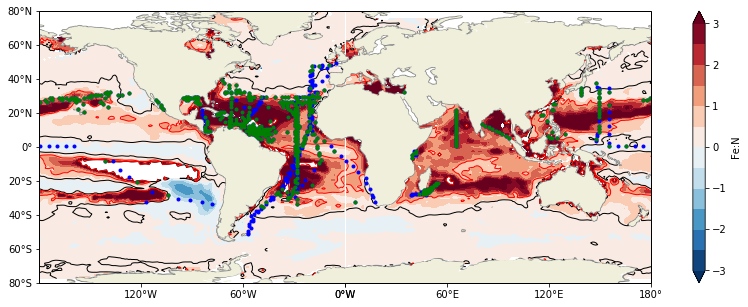

In [31]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
plt.plot(lon[find1[1]],lat[find1[0]],'.',color='b') #blue = observations
plt.plot(lon[find2[1]],lat[find2[0]],'.',color='g') #green = abundance
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()